In [4]:

import os
import re
import time
import random
from pathlib import Path
from typing import List, Tuple
import warnings
import argparse
import yaml

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.interpolate import interp1d
from scipy.optimize import least_squares
from scipy.ndimage import gaussian_filter1d

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_percentage_error
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split  

from tqdm import tqdm


warnings.filterwarnings('ignore')


R_GAS = 8.314  # J/(mol·K)
deg = 3
strain_min  = 0.05
strain_max  = 0.8
num_points = 20
interp_kind = "linear"  # ★ changed: default value
lam_smooth = float(1e-4)  # ★ changed: default value
loss = "soft_l1"  # ★ changed: default value
f_scale = float(10.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


data = torch.load('data.pt')

static_mean = data['static_mean']
static_std = data['static_std']
stress_mean = data['stress_mean']
stress_std = data['stress_std']


In [5]:

class FlexuralDataset(Dataset):
    def __init__(self, static_features, stress_sequences, cal_stress=None):
        """
        Args:
            cond_features: [num_samples, static_input_size]
            stress_sequences: [num_samples, seq_len, 1]
        """
        self.static = torch.FloatTensor(static_features)
        self.stress = torch.FloatTensor(stress_sequences)
        if cal_stress is not None:
            self.cal_stress = torch.as_tensor(cal_stress, dtype=torch.float32)
        else:
            self.cal_stress = None

    def __len__(self):
        return len(self.static)

    def __getitem__(self, idx):
        sample = {
            "static": self.static[idx],
            "stress": self.stress[idx]
        }
        
        if self.cal_stress is not None:
            sample["cal_stress"] = self.cal_stress[idx]
            
        return sample


def inverse_normalize_stress(data, mean=stress_mean, std=stress_std):
    return data * std + mean

def inverse_normalize_static(data, mean=static_mean, std=static_std):
    return data * std + mean



def polyval_forward(x: np.ndarray | float, coeffs: np.ndarray) -> np.ndarray | float:
    return np.polyval(coeffs, x)

def unpack_theta(theta: np.ndarray, deg: int):
    m = deg + 1
    c_lnalpha = theta[0*m:1*m]
    c_lnn     = theta[1*m:2*m]
    c_lnQ     = theta[2*m:3*m]
    c_lnA     = theta[3*m:4*m]
    return c_lnalpha, c_lnn, c_lnQ, c_lnA

def params_at_strain(eps: float, theta: np.ndarray, deg: int):
    c_lnalpha, c_lnn, c_lnQ, c_lnA = unpack_theta(theta, deg)
    ln_alpha = polyval_forward(eps, c_lnalpha)
    ln_n     = polyval_forward(eps, c_lnn)
    ln_Q     = polyval_forward(eps, c_lnQ)
    ln_A     = polyval_forward(eps, c_lnA)
    alpha = np.exp(ln_alpha)
    n     = np.exp(ln_n)
    Q     = np.exp(ln_Q)
    A     = np.exp(ln_A)
    return alpha, n, Q, A, ln_A

def predict_sigma(T: float, sr: float, eps: float, theta: np.ndarray, deg: int) -> float:
    alpha, n, Q, A, _ = params_at_strain(eps, theta, deg)
    z = (sr * np.exp(Q/(R_GAS*T))) ** (1.0/n) / (A ** (1.0/n))
    z = np.clip(z, 1e-12, 1e12)
    return np.arcsinh(z) / alpha


def residuals(theta: np.ndarray, temps: np.ndarray, srs: np.ndarray,
            eps_grid: np.ndarray, sigma_obs: np.ndarray,
            lam_smooth: float, deg: int, coef_weights: np.ndarray | None = None) -> np.ndarray:
    N, K = sigma_obs.shape
    res = np.empty(N*K, dtype=float)
    idx = 0
    for i in range(N):
        Ti = temps[i]; sri = srs[i]
        for k in range(K):
            eps = eps_grid[k]
            pred = predict_sigma(Ti, sri, eps, theta, deg)
            res[idx] = pred - sigma_obs[i, k]
            idx += 1
    if lam_smooth > 0.0:
        if coef_weights is None:
            smooth = np.sqrt(lam_smooth) * theta
        else:
            smooth = np.sqrt(lam_smooth) * coef_weights * theta
        res = np.concatenate([res, smooth])
    return res


def make_init_theta(deg: int) -> np.ndarray:
    m = deg + 1
    ln_alpha0 = np.log(1e-2)
    ln_n0     = np.log(5.0)
    ln_Q0     = np.log(1.2e5)
    ln_A0     = np.log(1e7)
    c_lnalpha = np.zeros(m); c_lnalpha[-1] = ln_alpha0
    c_lnn     = np.zeros(m); c_lnn[-1]     = ln_n0
    c_lnQ     = np.zeros(m); c_lnQ[-1]     = ln_Q0
    c_lnA     = np.zeros(m); c_lnA[-1]     = ln_A0
    return np.concatenate([c_lnalpha, c_lnn, c_lnQ, c_lnA])

def poly_coef_weights(deg: int, gamma: float = 1.0) -> np.ndarray:
    m = deg + 1
    w = np.concatenate([np.arange(1, m+1, dtype=float)]*4) ** gamma
    return w


def fit_theta(temps, srs, eps_grid, sigma_exper, lam_smooth, deg, loss, f_scale):
    theta0 = make_init_theta(deg)
    coef_w = poly_coef_weights(deg, gamma=1.0)
    t0 = time.time()
    res_lsq = least_squares(
        residuals, theta0,
        args=(temps, srs, eps_grid, sigma_exper, lam_smooth, deg, coef_w),
        loss=loss, f_scale=f_scale,
        x_scale='jac',
        max_nfev=20000, verbose=0,
        ftol=1e-9, xtol=1e-9, gtol=1e-9
    )
    dt = time.time() - t0
    return res_lsq, dt


def predict_grid(temps, srs, eps_grid, theta, deg):
    N, K = len(temps), len(eps_grid)
    pred = np.empty((N, K), dtype=float)
    for i in range(N):
        Ti, sri = temps[i], srs[i]
        for k, eps in enumerate(eps_grid):
            pred[i, k] = predict_sigma(Ti, sri, eps, theta, deg)
    return pred


def build_param_curves(eps_grid, theta, deg):
    alpha_curve = np.empty_like(eps_grid)
    n_curve     = np.empty_like(eps_grid)
    Q_curve     = np.empty_like(eps_grid)
    lnA_curve   = np.empty_like(eps_grid)
    for k, eps in enumerate(eps_grid):
        a, n_, Q_, A_, lnA_ = params_at_strain(eps, theta, deg)
        alpha_curve[k] = a; n_curve[k] = n_; Q_curve[k] = Q_; lnA_curve[k] = lnA_
    return alpha_curve, n_curve, Q_curve, lnA_curve

def try_parse_float(x: str) -> float | None:
    try:
        return float(x)
    except Exception:
        return None
    
def read_csv_robust(path: Path) -> pd.DataFrame:
    tried = []
    for enc in ["utf-8", "utf-8-sig", "gbk", "gb2312", "big5", "shift_jis", "cp932", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            tried.append(enc)
        except Exception as e:
            tried.append(f"{enc}({type(e).__name__})")
    raise UnicodeDecodeError("codec", b"", 0, 1, f"Unable read：{', '.join(tried)}")

def parse_temp_sr_from_filename(fname: str) -> Tuple[float, float]:
    """
    Support various formats: 1063_0.005.csv / T1063_SR0.005.csv / 1063K-0.005s-1.csv ...
    """
    stem = Path(fname).stem
    nums = re.findall(r"\d+\.?\d*", stem)
    if len(nums) >= 2:
        T = try_parse_float(nums[0])
        sr = try_parse_float(nums[1])
        if T is not None and sr is not None:
            return float(T), float(sr)
    raise ValueError(f"Unable to parse temperature/strain rate: {fname}")

def collect_csv_files(root: Path) -> List[Path]:
    csvs = [p for p in root.rglob("*.csv")]
    return sorted(csvs)

def read_and_interpolate(csv_files: List[Path],
                        strain_min: float,
                        strain_max: float,
                        num_points: int,
                        interp_kind: str = "cubic"):
    if len(csv_files) == 0:
        raise ValueError("No CSV files found in the ZIP.")
    eps_grid = np.linspace(strain_min, strain_max, num_points)

    temps, srs, sigma_rows = [], [], []
    bad_files = []

    for f in csv_files:
        try:
            T, sr = parse_temp_sr_from_filename(f.name)
        except Exception:
            bad_files.append((f.name, "Filename parsing failed"))
            continue

        try:
            df = read_csv_robust(f)
        except Exception as e:
            bad_files.append((f.name, f"Read failure：{e}"))
            continue

        cols_lower = {c.lower().strip(): c for c in df.columns}
        if "strain" not in cols_lower or "stress" not in cols_lower:
            bad_files.append((f.name, "lack column Strain/Stress"))
            continue

        strain = pd.to_numeric(df[cols_lower["strain"]], errors="coerce").to_numpy()
        stress = pd.to_numeric(df[cols_lower["stress"]], errors="coerce").to_numpy()
        mask = np.isfinite(strain) & np.isfinite(stress)
        strain, stress = strain[mask], stress[mask]

        if len(strain) < 2:
            bad_files.append((f.name, "Insufficient valid points"))
            continue

        order = np.argsort(strain)
        strain, stress = strain[order], stress[order]

        kind = interp_kind if len(strain) >= 4 else "linear"
        try:
            f_interp = interp1d(strain, stress, kind=kind, fill_value="extrapolate", assume_sorted=True)
        except Exception:
            f_interp = interp1d(strain, stress, kind="linear", fill_value="extrapolate", assume_sorted=True)

        sigma_point = f_interp(eps_grid)
        temps.append(T); srs.append(sr); sigma_rows.append(sigma_point)

    if len(sigma_rows) == 0:
        raise ValueError("No valid curves could be read. Please check filenames and column names/encoding.")

    temps = np.array(temps, dtype=float)
    srs = np.array(srs, dtype=float)
    sigma_exper = np.vstack(sigma_rows)
    return temps, srs, eps_grid, sigma_exper, bad_files


def save_stress_strain_curves(eps_grid, pred_sigma, sigma_exper, temps, srs):

    for i in range(len(temps)):

        T_str = str(int(temps[i]))
        SR_str = srs[i]

        SR_str = f"{SR_str:.3f}"
        file_name = f"./cal_data/{T_str}_{SR_str}.csv"
        df = pd.DataFrame({
            'y_true': sigma_exper[i],
            'y_cal': pred_sigma[i],
        })
        
        df.to_csv(file_name, index=False)
    
    


In [6]:


def prepare_dataset(exper_data, train_indices, stress_mean, stress_std, static_mean, static_std, batch_size=1, seed=42):

    exper_stress_data = exper_data["sigma_curve"].squeeze(2)
    exper_cal_stress_data = exper_data["cal_stress_curve"].squeeze(2)
    exper_static_data = exper_data["static_cond"]

    sorted_tensor = exper_static_data[:, 0, :]
    exper_static_data = sorted_tensor.unsqueeze(1).repeat(1, 20, 1)
    
    
    torch.set_printoptions(sci_mode=False)

    exper_static_data[:, :, 0:1] -= 273
    
    norm_exper_stress_data = (exper_stress_data - stress_mean) / stress_std
    norm_exper_cal_stress_data = (exper_cal_stress_data - stress_mean) / stress_std
    norm_exper_static_data = (exper_static_data - static_mean) / static_std

    norm_exper_stress_data = norm_exper_stress_data.float().unsqueeze(2)
    norm_exper_cal_stress_data = norm_exper_cal_stress_data.float().unsqueeze(2)
    norm_exper_static_data = norm_exper_static_data.float()

    exper_dataset = FlexuralDataset(norm_exper_static_data, norm_exper_stress_data, norm_exper_cal_stress_data)

    train_indices = train_indices
    
    val_indices = [i for i in range(len(exper_dataset)) if i not in train_indices]

    exper_train_dataset = torch.utils.data.Subset(exper_dataset, train_indices)
    exper_val_dataset = torch.utils.data.Subset(exper_dataset, val_indices)
    
    exper_train_loader = DataLoader(exper_train_dataset, batch_size=batch_size, shuffle=True)
    exper_val_loader = DataLoader(exper_val_dataset, batch_size=batch_size)
    
    print("Train loader size:", len(exper_train_loader))
    print("Validation loader size:", len(exper_val_loader))
    
    return exper_train_loader, exper_val_loader



class ConditionalAE(nn.Module):
    def __init__(self,
                seq_len=20,
                z_dim=16,
                hidden_dim=64,
                process_dim=2,
                stress_dim=1):
        super().__init__()
        self.seq_len = seq_len
        self.process_dim = process_dim
        self.stress_dim = stress_dim

        # split latent dimensions
        assert z_dim % 2 == 0, "z_dim must be even"
        self.z_dim_data = z_dim // 2       # data‐latent part
        self.z_dim_cond = z_dim - self.z_dim_data  # condition‐latent part

        # ================= Encoder =================
        enc_input_dim = process_dim + stress_dim
        self.enc_rnn = nn.LSTM(
            input_size=enc_input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        # deterministic data‐latent
        self.fc_mu_data = nn.Linear(2*hidden_dim, self.z_dim_data)
        # deterministic cond‐latent
        self.cond_aggregator = nn.Sequential(
            nn.Linear(seq_len * process_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.z_dim_cond)
        )

        # ================= Decoder =================
        # FiLM generator: from z_cond to scale+shift for hidden state
        self.film_gen = nn.Linear(self.z_dim_cond, 2 * hidden_dim)
        # LSTMCell decoder
        dec_input_dim = z_dim + process_dim
        self.dec_cell = nn.LSTMCell(input_size=dec_input_dim, hidden_size=hidden_dim)
        # stress output
        self.out_lin = nn.Linear(hidden_dim, stress_dim)

        # ================= Auxiliary predictor (optional) =================
        self.c_predictor = nn.Sequential(
            nn.Linear(seq_len * stress_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len * process_dim)
        )

    def encode(self, x, c):
        """
        x: [B, T, 1]
        c: [B, T, process_dim]
        returns:
        z:      [B, z_dim] = [z_data, z_cond]
        z_data: [B, z_dim_data]
        z_cond: [B, z_dim_cond]
        """
        inp = torch.cat([x, c], dim=-1)            # [B, T, enc_input_dim]
        out, _ = self.enc_rnn(inp)                 # [B, T, 2H]
        h_last = out[:, -1, :]                     # [B, 2H]

        # deterministic z_data
        z_data = self.fc_mu_data(h_last)           # [B, z_dim_data]

        # deterministic z_cond
        c_flat = c.view(c.size(0), -1)             # [B, T*process_dim]
        z_cond = self.cond_aggregator(c_flat)      # [B, z_dim_cond]

        # full latent
        z = torch.cat([z_data, z_cond], dim=1)     # [B, z_dim]
        return z, z_data, z_cond

    def decode(self, z, c_new):
        """
        z:      [B, z_dim]
        c_new:  [B, T, process_dim]
        """
        # split
        z_data, z_cond = torch.split(z, [self.z_dim_data, self.z_dim_cond], dim=1)
        B, T, _ = c_new.shape

        # FiLM params
        film_params = self.film_gen(z_cond)        # [B, 2*hidden_dim]
        gamma, beta = torch.split(film_params, film_params.shape[1]//2, dim=1)

        # init
        h = torch.zeros(B, self.dec_cell.hidden_size, device=z.device)
        c_state = torch.zeros_like(h)
        outputs = []
        # prev_y = torch.zeros(B, 1, device=z.device)

        for t in range(T):
            ct = c_new[:, t, :]                     # [B, process_dim]
            inp = torch.cat([z, ct], dim=1)         # [B, z_dim+proc_dim]
            h, c_state = self.dec_cell(inp, (h, c_state))
            # apply FiLM
            h = gamma * h + beta
            y_t = self.out_lin(h)                   # [B, 1]

            # # teacher forcing if desired
            # if (teacher is not None) and (random.random() < tf_ratio):
            #     prev_y = teacher[:, t:t+1, :]
            # else:
            #     prev_y = y_t

            outputs.append(y_t)

        return torch.stack(outputs, dim=1)         # [B, T, 1]

    def forward(self, x, c, c_new):
        # encode
        z, z_data, z_cond = self.encode(x, c)
        # decode recon & gen
        rec = self.decode(z, c)
        gen = self.decode(z, c_new)

        # auxiliary recon of c (optional, for additional loss)
        gen_flat = gen.view(gen.size(0), -1)
        c_recon  = self.c_predictor(gen_flat)
        c_recon  = c_recon.view(-1, self.seq_len, self.process_dim)

        return {
            'rec':     rec,       # [B,T,1]
            'gen':     gen,       # [B,T,1]
            'z_data':  z_data,    # [B, z_dim_data]
            'z_cond':  z_cond,    # [B, z_dim_cond]
            'c_recon': c_recon    # [B, T, process_dim]
        }




config = {
    "batch_size": 128,
    "epochs": 100,
    "lr": 1e-3,
    "z_dim": 16,
    "hidden_dim": 128,
    "seq_len": 8,
    "process_dim": 2,
    "min_tf": 0.1,
    "patience": 10,
    "seed": 42,
    "cuda": True,
    "ckpt_path": "DeformPTM.pth",
    "cond_weight": 1.0
}


# 1) Load DeformPTM AE model
model = ConditionalAE(
    seq_len=20,
    z_dim=config['z_dim'],
    hidden_dim=config['hidden_dim'],
    process_dim=config['process_dim'],
    stress_dim=1
).to(device)
model.load_state_dict(torch.load(config['ckpt_path'], map_location=device))
model.eval()

# 2) Freeze Bi‑LSTM encoder
for param in model.enc_rnn.parameters():
    param.requires_grad = False

# 3) Unfreeze latter half of encoder and entire decoder
for param in model.fc_mu_data.parameters():      # data‑latent
    param.requires_grad = True
for param in model.cond_aggregator.parameters(): # cond‑latent
    param.requires_grad = True

for param in model.film_gen.parameters():
    param.requires_grad = True
for param in model.dec_cell.parameters():
    param.requires_grad = True
for param in model.out_lin.parameters():
    param.requires_grad = True
for param in model.c_predictor.parameters():     # optional
    param.requires_grad = True

# 4) Construct optimizer with only unfrozen parameters
optim = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=1e-6
)


def predict_on_loader(model, loader, device):
    model.eval()
    all_pred, all_true, all_c = [], [], []
    with torch.no_grad():
        for batch in loader:
            if 'cal_stress' in batch:
                cal_x = batch['cal_stress'].to(device)    # [B, T, 1]
                x = batch['stress'].to(device)        # [B, T, 1]
            else:
                cal_x = batch['stress'].to(device) 
                x = batch['stress'].to(device)        # [B, T, 1]
            c = batch['static'].to(device)    # [B, T, process_dim]


            # encode -> (z, z_data, z_cond)
            z, z_data, z_cond = model.encode(cal_x, c)
            # decode（teacher=None, tf_ratio=0）
            pred = model.decode(z, c)  # [B, T, 1]

            all_pred.append(pred.cpu())
            all_true.append(x.cpu())
            all_c.append(c.cpu())

    return torch.cat(all_pred, dim=0), torch.cat(all_true, dim=0), torch.cat(all_c, dim=0)


def finetune_model(model, optim, exper_train_loader, device,
                epochs=150,
                model_save_path='pretrain_finetuned.pth'):
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0.0
        n_samples = 0

        for batch in exper_train_loader:
            x = batch['cal_stress'].to(device)   # [B, T, 1]
        
            c = batch['static'].to(device)   # [B, T, proc_dim]
    
            real_x = batch['stress'].to(device)   # [B, T, 1]
            
            optim.zero_grad()
            out = model(x, c, c_new=c)
            rec = out['rec']                 # [B, T, 1]

            loss = F.mse_loss(rec, real_x) 

            loss.backward()
            optim.step()

            bsz = x.size(0)
            total_loss += loss.item() * bsz
            n_samples += bsz

        avg_loss = total_loss / n_samples
        # print(f"[Finetune] Epoch {epoch}/{epochs} | avg loss = {avg_loss:.6f}")

    # Save the fine-tuned model
    torch.save(model.state_dict(), model_save_path)
    return model




# LOO performance

In [7]:
csv_files = collect_csv_files(Path("./alloy_dataset/AQ80"))  # Adjust the path as needed

# ===========================================
# LOO
# ===========================================

all_metrics = []

def format_condition(c_tensor):

    c_np = c_tensor.detach().cpu().numpy().astype(float).ravel()
    t_str = f"{c_np[0]:.3f}"
    sr_str = f"{c_np[1]:.3f}"
    return t_str, sr_str

for leave_out_idx in range(len(csv_files)):
    print(f"\n========== LOO round {leave_out_idx+1}/{len(csv_files)} ==========")
    
    train_indices = [i for i in range(len(csv_files)) if i != leave_out_idx]
    test_indices = [leave_out_idx]

    train_files = [csv_files[i] for i in train_indices]
    test_files  = [csv_files[i] for i in test_indices]

    print("Number of training files:", len(train_files), "| Number of testing files:", len(test_files))
    print("Testing files:", test_files)

    # ========= Training phase =========
    temps_train, srs_train, eps_grid_train, sigma_exper_train, bad_files_train = read_and_interpolate(
        train_files, float(strain_min), float(strain_max), int(num_points), interp_kind
    )

    t0 = time.time()
    res_lsq_train, dt_train = fit_theta(
        temps_train, srs_train, eps_grid_train, sigma_exper_train,
        float(lam_smooth), int(deg), loss, float(f_scale)
    )
    theta_hat_train = res_lsq_train.x
    t1 = time.time()

    pred_sigma_train = predict_grid(temps_train, srs_train, eps_grid_train, theta_hat_train, int(deg))


    # ========= Testing phase =========
    temps_test, srs_test, eps_grid_test, sigma_exper_test, bad_files_test = read_and_interpolate(
        test_files, float(strain_min), float(strain_max), int(num_points), interp_kind
    )

    pred_sigma_test = predict_grid(temps_test, srs_test, eps_grid_test, theta_hat_train, int(deg))

    mse_test  = mean_squared_error(sigma_exper_test.ravel(), pred_sigma_test.ravel())
    rmse_test = float(np.sqrt(mse_test))
    r2_test   = float(r2_score(sigma_exper_test.ravel(), pred_sigma_test.ravel()))
    mape_test = float(mean_absolute_percentage_error(sigma_exper_test.ravel(), pred_sigma_test.ravel()))

    metrics_test = {
        "rmse": rmse_test,
        "r2": r2_test,
        "mape": mape_test,
        "test_file": test_files[0],
    }

    print("Testing set evaluation metrics:", metrics_test)
    all_metrics.append(metrics_test)
    save_stress_strain_curves(eps_grid_test, pred_sigma_test, sigma_exper_test, temps_test, srs_test)

    # ========= Construct exper_data and save =========
    T_exper_train = torch.tensor(temps_train, dtype=torch.float32)
    ε̇_exper_train = torch.tensor(srs_train, dtype=torch.float32)
    cal_stress_curve_train = torch.tensor(pred_sigma_train, dtype=torch.float32)
    sigma_exper_train_t = torch.tensor(sigma_exper_train, dtype=torch.float32)

    T_exper_test = torch.tensor(temps_test, dtype=torch.float32)
    ε̇_exper_test = torch.tensor(srs_test, dtype=torch.float32)
    cal_stress_curve_test = torch.tensor(pred_sigma_test, dtype=torch.float32)
    sigma_exper_test_t = torch.tensor(sigma_exper_test, dtype=torch.float32)

    # Concatenate training and testing data (for convenient fine-tuning)
    T_exper = torch.cat([T_exper_train, T_exper_test], dim=0)
    ε̇_exper = torch.cat([ε̇_exper_train, ε̇_exper_test], dim=0)
    cal_stress_curve = torch.cat([cal_stress_curve_train, cal_stress_curve_test], dim=0)
    sigma_exper = torch.cat([sigma_exper_train_t, sigma_exper_test_t], dim=0)

    exper_data = {
        "T_scalar": T_exper.unsqueeze(1),           # [B,1]
        "ε̇_scalar": ε̇_exper.unsqueeze(1),
        "sigma_curve": sigma_exper.unsqueeze(2),    # [B,K,1]
        "cal_stress_curve": cal_stress_curve.unsqueeze(2),
    }

    exper_data["static_cond"] = torch.cat(
        [exper_data["T_scalar"], exper_data["ε̇_scalar"]], dim=1
    ).unsqueeze(1).repeat(1, num_points, 1)


    exper_data["sigma_curve"] = torch.tensor(
        gaussian_filter1d(exper_data["sigma_curve"].squeeze(2).numpy(), sigma=1),
        dtype=torch.float32
    ).unsqueeze(2)


    train_indices_nn = [i for i in range(len(temps_train))]  # Only training samples
    exper_train_loader, exper_val_loader = prepare_dataset(exper_data,train_indices=train_indices_nn, stress_mean=stress_mean, stress_std=stress_std, static_mean=static_mean, static_std=static_std,batch_size=1, seed=0)

    model_finetuned = finetune_model(model, optim, exper_train_loader, device, epochs=100, model_save_path='pretrain_finetuned.pth')


    model_finetuned.eval()

    torch.manual_seed(1)
    preds, trues, condition = predict_on_loader(model_finetuned, exper_val_loader, device)     # preds, trues： [N, T, 1]

    K = len(exper_val_loader)

    print("size of val dataset", K)
    time_steps = list(range(preds.shape[1]))

    pred_list = []
    true_list = []


    per_sample_data = []   

    for i in range(K):
        y_true = trues[i, :, 0].float().detach().cpu()
        y_pred = preds[i, :, 0].float().detach().cpu()
        c_label = condition[i, 0, :].float().detach().cpu()

        y_true = inverse_normalize_stress(y_true, stress_mean.float(), stress_std.float())
        y_pred = inverse_normalize_stress(y_pred, stress_mean.float(), stress_std.float())
        c_true = inverse_normalize_static(c_label, static_mean.float(), static_std.float())

        T_str, SR_str = format_condition(c_true)
        T_str = int(float(T_str)) + 273  
        file_name = f"./pred_data/{T_str}_{SR_str}.csv"

        df = pd.DataFrame({
            'y_true': y_true.detach().cpu().numpy(),
            'y_pred': y_pred.detach().cpu().numpy()
        })
        df.to_csv(file_name, index=False) 

    
        r2 = r2_score(y_true.numpy(), y_pred.numpy())
  
        mse = mean_squared_error(y_true.numpy(), y_pred.numpy())
        rmse = float(np.sqrt(mse))
        print(f"样本 {i+1}/{K} | T={T_str} K, SR={SR_str} s^-1 | R²={r2:.4f}, RMSE={rmse:.4f}")



========== LOO round 1/16 ==========
Number of training files: 15 | Number of testing files: 1
Testing files: [WindowsPath('alloy_dataset/AQ80/523_0.001.csv')]
Testing set evaluation metrics: {'rmse': 8.863059062665075, 'r2': 0.2825340410003895, 'mape': 0.1251865955300701, 'test_file': WindowsPath('alloy_dataset/AQ80/523_0.001.csv')}
Train loader size: 15
Validation loader size: 1
size of val dataset 1
样本 1/1 | T=523 K, SR=0.001 s^-1 | R²=0.7475, RMSE=5.1682

========== LOO round 2/16 ==========
Number of training files: 15 | Number of testing files: 1
Testing files: [WindowsPath('alloy_dataset/AQ80/523_0.010.csv')]
Testing set evaluation metrics: {'rmse': 12.71061602069071, 'r2': -0.8445252850098279, 'mape': 0.13594380082175578, 'test_file': WindowsPath('alloy_dataset/AQ80/523_0.010.csv')}
Train loader size: 15
Validation loader size: 1
size of val dataset 1
样本 1/1 | T=523 K, SR=0.010 s^-1 | R²=0.1474, RMSE=8.4437

========== LOO round 3/16 ==========
Number of training files: 15 | N

# Prediction

In [8]:
csv_files = collect_csv_files(Path("alloy_dataset/HIP-FGH4113A"))  # Adjust the path as needed

print(f"Found {len(csv_files)} CSV files.")

temps, srs, eps_grid, sigma_exper, bad_files = read_and_interpolate(
    csv_files, float(strain_min), float(strain_max), int(num_points), interp_kind
)

res_lsq, dt = fit_theta(temps, srs, eps_grid, sigma_exper, float(lam_smooth), int(deg), loss, float(f_scale))

theta_hat = res_lsq.x

cal_sigma = predict_grid(temps, srs, eps_grid, theta_hat, int(deg))

# -------------------------
T_exper = torch.tensor(temps, dtype=torch.float32).unsqueeze(1)         # (n_samples, 1)
SR_exper = torch.tensor(srs, dtype=torch.float32).unsqueeze(1)          # (n_samples, 1)
sigma_cal_tensor = torch.tensor(cal_sigma, dtype=torch.float32).unsqueeze(2)        # (n_samples, n_points, 1)

sigma_exper_tensor = torch.tensor(np.vstack(sigma_exper), dtype=torch.float32).unsqueeze(2)  # (n_samples, n_points, 1)

n_points = sigma_exper_tensor.shape[1]
static_cond = torch.cat([T_exper, SR_exper], dim=1) 
static_cond = static_cond.unsqueeze(1).repeat(1, n_points, 1)  # (n_samples, n_points, 2)


exper_data = {
    "T_scalar": T_exper,                        # (n_samples, 1)
    "ε̇_scalar": SR_exper,                       # (n_samples, 1)
    "sigma_exper_curve": sigma_exper_tensor,    # (n_samples, n_points, 1)
    "sigma_cal_curve": sigma_cal_tensor,        # (n_samples, n_points, 1)
    "static_cond": static_cond,                 # (n_samples, n_points, 2)
}           
exper_stress_data = exper_data["sigma_exper_curve"].squeeze(2)
exper_cal_stress_data = exper_data["sigma_cal_curve"].squeeze(2)
exper_static_data = exper_data["static_cond"]
exper_static_data[:, :, 0:1] -= 273 # T to °C

norm_exper_stress_data = (exper_stress_data - stress_mean) / stress_std
norm_exper_cal_stress_data = (exper_cal_stress_data - stress_mean) / stress_std
norm_exper_static_data = (exper_static_data - static_mean) / static_std


norm_exper_stress_data = norm_exper_stress_data.float().unsqueeze(2)
norm_exper_cal_stress_data = norm_exper_cal_stress_data.float().unsqueeze(2)
norm_exper_static_data = norm_exper_static_data.float()

exper_dataset = FlexuralDataset(norm_exper_static_data, norm_exper_stress_data, norm_exper_cal_stress_data)

exper_dataloader = DataLoader(exper_dataset, batch_size=1, shuffle=True)

# model_finetuned_all = finetune_model(model, optim, exper_train_loader, device, epochs=500, model_save_path='DeformPTM_fintuned.pth')



Found 6 CSV files.


In [9]:
model_finetuned_all = ConditionalAE(
    seq_len=20,
    z_dim=config['z_dim'],
    hidden_dim=config['hidden_dim'],
    process_dim=config['process_dim'],
    stress_dim=1
).to(device)

state = torch.load('DeformPTM_fintuned.pth', map_location=device)
model_finetuned_all.load_state_dict(state)
model_finetuned_all.eval()


temps_test = 1273
srs_test = 0.001

def inference(temps_test, srs_test, eps_grid, theta_hat, deg):
    pred_sigma =  predict_grid([temps_test], [srs_test], eps_grid, theta_hat, int(deg))

    T_exper = torch.tensor([temps_test], dtype=torch.float32).unsqueeze(1)      # (1, 1)
    SR_exper = torch.tensor([srs_test], dtype=torch.float32).unsqueeze(1)      # (1, 1)
    sigma_pred_tensor = torch.tensor(pred_sigma, dtype=torch.float32).unsqueeze(2)  # (1, n_points, 1)

    static_cond = torch.cat([T_exper, SR_exper], dim=1)  # (n_samples, 2)
    static_cond = static_cond.unsqueeze(1).repeat(1, 20, 1)  # (n_samples, n_points, 2)
    infer_data = {
        "T_scalar": T_exper,                        # (n_samples, 1)
        "ε̇_scalar": SR_exper,                       # (n_samples, 1)
        "sigma_pred_curve": sigma_pred_tensor,      # (n_samples, n_points, 1)
        "static_cond": static_cond,                 # (n_samples, n_points, 2)
    }
    exper_pred_stress_data = infer_data["sigma_pred_curve"].squeeze(2)
    exper_static_data = infer_data["static_cond"]
    exper_static_data[:, :, 0:1] -= 273 # T to °C

    norm_exper_pred_stress_data = (exper_pred_stress_data - stress_mean) / stress_std
    norm_exper_static_data = (exper_static_data - static_mean) / static_std

    norm_exper_pred_stress_data = norm_exper_pred_stress_data.float().unsqueeze(2)
    norm_exper_static_data = norm_exper_static_data.float()

    exper_dataset = FlexuralDataset(norm_exper_static_data, norm_exper_pred_stress_data, norm_exper_pred_stress_data)

    exper_dataloader = DataLoader(exper_dataset, batch_size=1, shuffle=True)

    model_finetuned_all.eval()
    torch.manual_seed(1)
    preds, _, condition = predict_on_loader(model_finetuned_all, exper_dataloader, device)

    y_pred = preds[:, :, 0].float().detach().cpu()
    c_label = condition[:, 0, :].float().detach().cpu()

    y_pred = inverse_normalize_stress(y_pred, stress_mean.float(), stress_std.float())
    c_true = inverse_normalize_static(c_label, static_mean.float(), static_std.float())

    T_str, SR_str = format_condition(c_true)
    T_str = int(float(T_str)) + 273         
    return y_pred, T_str, SR_str

y_pred, T_str, SR_str = inference(temps_test, srs_test, eps_grid, theta_hat, deg)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=eps_grid,
    y=y_pred.squeeze().numpy(),
    mode='markers',
    marker=dict(
        size=8,
        color='royalblue',
        opacity=0.7,
        line=dict(width=1, color='darkblue')
    ),
    name='Predicted Points'
))

fig.add_trace(go.Scatter(
    x=eps_grid,
    y=y_pred.squeeze().numpy(),
    mode='lines',
    line=dict(color='lightblue', width=2, dash='dot'),
    name='Trend Line'
))

fig.update_layout(
    title=f'Predicted Stress-Strain Curve at T={T_str} K, Strain Rate={SR_str} s⁻¹',
    xaxis_title='Strain (ε)',
    yaxis_title='Stress (σ, MPa)',
    template='simple_white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

fig.show()




## Optimization


[1.33779339e+03 2.00000000e-01] [104.62785234]


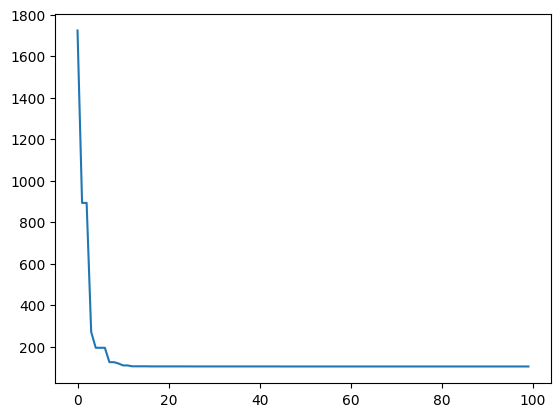

In [9]:
import matplotlib.pyplot as plt
from sko.PSO import PSO

df = pd.read_csv('./target1.csv').values
y_exper_target = df[:, 1]


def opt_func(params):
    T, SR = params
    y_pred, _, _ = inference(T, SR, eps_grid, theta_hat, deg)

    y_pred_np = y_pred.squeeze().numpy()
    mse = mean_squared_error(y_exper_target, y_pred_np)
    return mse



pso = PSO(func=opt_func, dim=2, pop=30, max_iter=100, lb=[1173,0.001], ub=[1473,0.2])
best_x, best_y = pso.run()
print(best_x, best_y)


plt.plot(pso.gbest_y_hist)
plt.show()


## ANN Performance

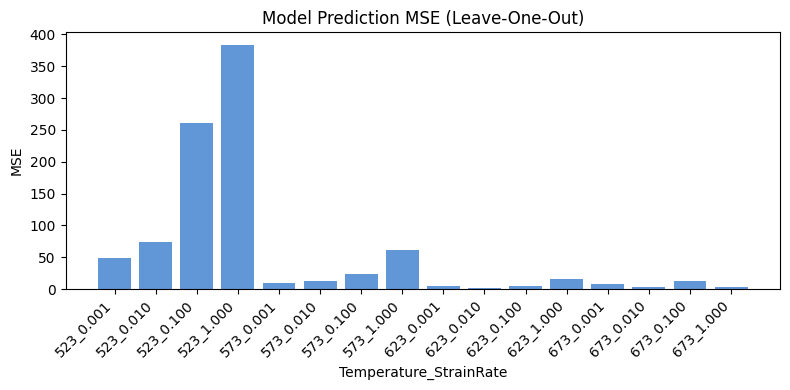

✅ 已保存 metrics_summary.csv 与 MSE 柱状图 results/MSE_bar_chart.png


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = "alloy_dataset/AQ80_LOO/cal_data"
strain = np.linspace(0.05, 0.6, 20)

# ===================== ANN =====================
class ANN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

def parse_filename(fname):
    match = re.match(r"(\d+)_([\d\.]+)\.csv", fname)
    if match:
        T = float(match.group(1))
        sr = float(match.group(2))
        return T, np.log(sr)
    return None, None

def load_dataset(path):
    files = [f for f in os.listdir(path) if f.endswith(".csv")]
    dataset = []
    for f in files:
        T, sr = parse_filename(f)
        df = pd.read_csv(os.path.join(path, f))
        y = df["y_true"].values.reshape(-1, 1)
        eps = strain.reshape(-1, 1)
        T_col = np.full_like(eps, T)
        sr_col = np.full_like(eps, sr)
        X = np.hstack([eps, T_col, sr_col])
        dataset.append({"file": f, "X": X, "y": y, "T": T, "sr": sr})
    return dataset

# ===================== Leave-One-Out =====================
dataset = load_dataset(data_path)
os.makedirs("results_ann", exist_ok=True)
os.makedirs("pred_csv_ann", exist_ok=True)

metrics_list = []  

for i, test_case in enumerate(dataset):
    train_cases = [d for j, d in enumerate(dataset) if j != i]
    X_train = np.vstack([d["X"] for d in train_cases])
    y_train = np.vstack([d["y"] for d in train_cases])

    X_test = test_case["X"]
    y_test = test_case["y"]
    test_name = test_case["file"]
    T, sr = test_case["T"], test_case["sr"]

    x_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    X_train_scaled = x_scaler.transform(X_train)
    y_train_scaled = y_scaler.transform(y_train)
    X_test_scaled = x_scaler.transform(X_test)

    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=128, shuffle=True)


    model = ANN(input_dim=3, hidden_dim=64).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(400):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_t).cpu().numpy()
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
        y_true = y_test_t.cpu().numpy()

    mse = mean_squared_error(y_true, y_pred)
    # rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    sr = np.exp(sr)
    metrics_list.append({
        "file": f"{int(T)}_{sr:.3f}",
        "MSE": mse,
        "R2": r2
    })

    df_out = pd.DataFrame({
        "strain": strain.flatten(),
        "y_true": y_true.flatten(),
        "y_pred": y_pred.flatten()
    })
    
    save_csv = f"pred_csv/{int(T)}_{sr:.3f}.csv"

    df_out.to_csv(save_csv, index=False)

    # ======== Vis ========
    plt.figure(figsize=(4, 3))
    plt.plot(strain, y_true, 'o-', label='True', lw=2)
    plt.plot(strain, y_pred, 's--', label='Pred', lw=2)
    plt.xlabel("Strain")
    plt.ylabel("Stress")
    plt.title(f"{int(T)}K, ε̇={sr:.3f}\nRMSE={mse:.2f}, R²={r2:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results/{int(T)}_{sr:.3f}.png", dpi=300)
    plt.close()
# ===================== Summary and plot =====================
df_metrics = pd.DataFrame(metrics_list)
# df_metrics.to_csv("metrics_summary.csv", index=False)


df_metrics = df_metrics.sort_values("file")

df_deform_pred = pd.read_csv("alloy_dataset/AQ80_LOO/fig_out/mse_results.csv")

plt.figure(figsize=(8, 4))
plt.bar(df_metrics["file"], df_metrics["MSE"], color="#3A7DCE", alpha=0.8)
plt.xticks(rotation=45, ha="right")
plt.ylabel("MSE")
plt.xlabel("Temperature_StrainRate")
plt.title("Model Prediction MSE (Leave-One-Out)")
plt.tight_layout()
plt.savefig("results/MSE_bar_chart.png", dpi=300)
plt.show()

print("✅ All done!")



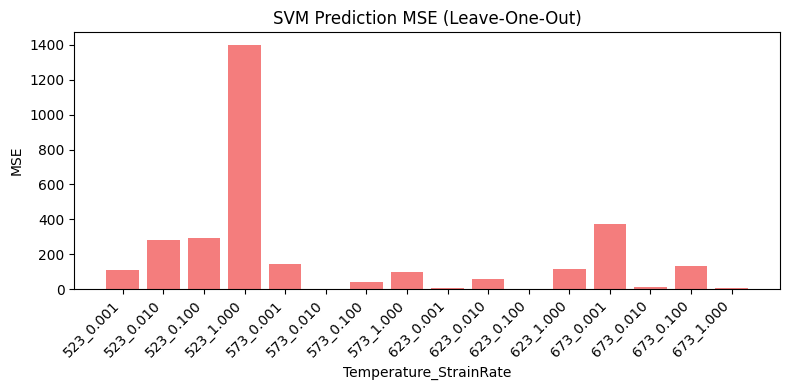

✅ All done!


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

data_path = "alloy_dataset/AQ80_LOO/cal_data"
strain = np.linspace(0.05, 0.6, 20)

def parse_filename(fname):
    match = re.match(r"(\d+)_([\d\.]+)\.csv", fname)
    if match:
        T = float(match.group(1))
        sr = float(match.group(2))
        return T, np.log(sr)
    return None, None

def load_dataset(path):
    files = [f for f in os.listdir(path) if f.endswith(".csv")]
    dataset = []
    for f in files:
        T, sr = parse_filename(f)
        df = pd.read_csv(os.path.join(path, f))
        y = df["y_true"].values.reshape(-1, 1)
        eps = strain.reshape(-1, 1)
        T_col = np.full_like(eps, T)
        sr_col = np.full_like(eps, sr)
        X = np.hstack([eps, T_col, sr_col])
        dataset.append({"file": f, "X": X, "y": y, "T": T, "sr": sr})
    return dataset

# ===================== LOO + SVM =====================
dataset = load_dataset(data_path)
os.makedirs("results_svm", exist_ok=True)
os.makedirs("pred_csv_svm", exist_ok=True)

metrics_list = []

for i, test_case in enumerate(dataset):
    train_cases = [d for j, d in enumerate(dataset) if j != i]
    X_train = np.vstack([d["X"] for d in train_cases])
    y_train = np.vstack([d["y"] for d in train_cases]).ravel()  
    X_test = test_case["X"]
    y_test = test_case["y"].ravel()
    T, sr = test_case["T"], test_case["sr"]

    x_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))
    X_train_scaled = x_scaler.transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).ravel()

    # ======== SVM  ========
    svr = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale')
    svr.fit(X_train_scaled, y_train_scaled)

    # ======== Predict ========
    y_pred_scaled = svr.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
    # ======== Calculate metrics ========
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    sr = np.exp(sr)

    metrics_list.append({
        "file": f"{int(T)}_{sr:.3f}",
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

    # ======== Save prediction results ========
    df_out = pd.DataFrame({
        "strain": strain.flatten(),
        "y_true": y_test.flatten(),
        "y_pred": y_pred.flatten()
    })

    
    save_csv = f"pred_csv_svm/{int(T)}_{sr:.3f}.csv"
    df_out.to_csv(save_csv, index=False)

    # ======== Vis ========
    plt.figure(figsize=(4, 3))
    plt.plot(strain, y_test, 'o-', label='True', lw=2)
    plt.plot(strain, y_pred, 's--', label='Pred', lw=2)
    plt.xlabel("Strain")
    plt.ylabel("Stress")
    plt.title(f"SVM: {int(T)}K, ε̇={sr:.3f}\nRMSE={rmse:.2f}, R²={r2:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results_svm/{int(T)}_{sr:.3f}.png", dpi=300)
    plt.close()

# ===================== Summary and plot =====================
df_metrics = pd.DataFrame(metrics_list)
# df_metrics.to_csv("metrics_summary_svm.csv", index=False)

# Sort for better display
df_metrics = df_metrics.sort_values("file")

plt.figure(figsize=(8, 4))
plt.bar(df_metrics["file"], df_metrics["MSE"], color="#F25C5C", alpha=0.8)
plt.xticks(rotation=45, ha="right")
plt.ylabel("MSE")
plt.xlabel("Temperature_StrainRate")
plt.title("SVM Prediction MSE (Leave-One-Out)")
plt.tight_layout()
plt.savefig("results_svm/MSE_bar_chart_svm.png", dpi=300)
plt.show()

print("✅ All done!")